In [1]:
import os
import shutil
import flopy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# ! Custom modules
from utils import pht3d_fsp
from utils.tools import calculate_MAS_sums, clear_directory
from utils.pht3d_utils import copy_pht3d_datab, run_pht3d_program

clear_directory()

In [2]:
data_folder = 'test1'
model_name = 'test1_modflow'
model_ws = './models_folder/' + data_folder

# ! 构建 MODFLOW 模型
mf = flopy.modflow.Modflow(modelname=model_name, exe_name='./bin/mf2005', model_ws=model_ws)

Lx = 2000
Ly = 100
Lz = 10

nlay = 20
nrow = 1
ncol = 20

delr = Lx / ncol
delc = Ly / nrow

ztop = 2000
zbot = ztop - Lz
botm = np.linspace(ztop, zbot, nlay+1)[1:]

nper = 1
perlen = [365,]
nstp = [30,]
steady = [True,]

dis = flopy.modflow.ModflowDis(mf, 
    nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc,
    top=ztop, botm=botm, 
    nper=nper, perlen=perlen, nstp=nstp, itmuni=4
)

ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
strt = 2000 * np.ones((nlay, nrow, ncol), dtype=np.float32)
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

laytyp = 0
hk = np.ones((nlay, nrow, ncol), dtype=np.float32)
hk[:, :, :] = 12.7  # 1.474 * (10 ** (-4))
hk[:, 10:18, 4:18] = 0.0127  # 1.474 * (10 ** (-7))
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, vka=hk*0.001, laytyp=laytyp, ipakcb=1)

wel_spd = {0: [[0, 0, 15, -1163.0]]}
wel = flopy.modflow.ModflowWel(mf, stress_period_data=wel_spd)

# 创建一个CHD包（定头边界包）
stress_period_data_chd = {0: [[0, 0, 0, 1980.0, 1970.0],]}
chd = flopy.modflow.ModflowChd(mf, stress_period_data=stress_period_data_chd)

# 创建一个GHB包（广义定头边界包）
stress_period_data_ghb = {0: [[0, 0, ncol-1, 1985.0, 10.0],]}
ghb = flopy.modflow.ModflowGhb(mf, stress_period_data=stress_period_data_ghb)

stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = ["save head", "save drawdown", 
                                            "save budget", "print head", "print budget",]
oc = flopy.modflow.ModflowOc(mf, stress_period_data=stress_period_data, compact=True)

pcg = flopy.modflow.ModflowPcg(mf)

lmt = flopy.modflow.ModflowLmt(mf, output_file_name='mt3d_link.ftl')

mf.write_input()

success, mfoutput = mf.run_model(pause=False, report=False, silent=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

C:\Users\wang\AppData\Local\Temp\ipykernel_16120\920851514.py:12: UserWarning: The following kwargs were not used by contour: 'aspect'
  plt.contour(head[:, 0, :], colors="black", aspect='auto', linestyles='dashed')


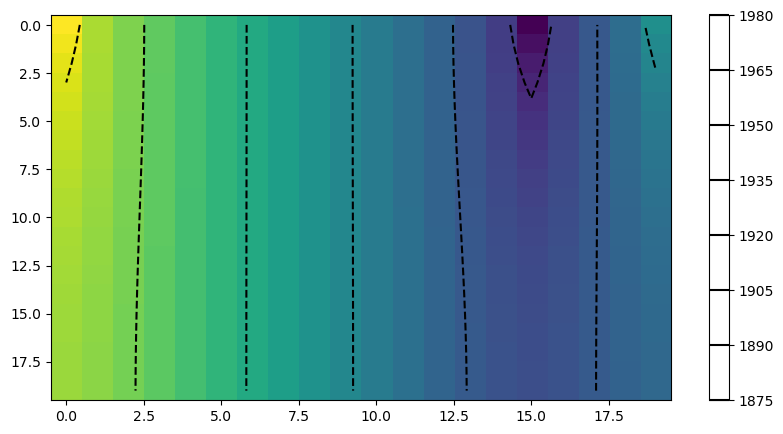

In [4]:
head = flopy.utils.HeadFile(model_ws + '/' + model_name + '.hds')
# plt.imshow(head[:, 0, :], extent=(0, ncol*delr, botm[-1], ztop), cmap='viridis', aspect='auto')
# plt.colorbar(label='Head (m)')
# plt.xlabel('Distance (m)')
# plt.ylabel('Elevation (m)')
# plt.title('Head distribution')
# plt.show()
head = head.get_data()
plt.figure(figsize=(10, 5))
# extent = (0, ncol * delr, botm[-1], ztop)
plt.imshow(head[:, 0, :], cmap='viridis', aspect='auto')
plt.contour(head[:, 0, :], colors="black", aspect='auto', linestyles='dashed')

plt.colorbar()
# plt.contour(head[:, 0, :], colors='white')
# plt.grid()

In [6]:
## Create PHT3D Reactive Transport Model, supported by PHT3D-FSP
## Define "spec", calling PHT3D-FSP (adopt function variables as needed)
## 需要安装 openpyxl 模块 !pip install openpyxl
spec = pht3d_fsp.create(
    xlsx_path="./", 
    xlsx_name=f"./data/{data_folder}/pht3d_species.xlsx",
    nlay=nlay, 
    nrow=nrow, 
    ncol=ncol,
    ph_os=2,
    ph_temp=25,
    ph_asbin=1,
    ph_eps_aqu=1e-10,
    ph_ph=1e-3,
    # ph_print=0,
    ph_cb_offset=0,
    # ph_surf_calc_type="-diffuse_layer",
    write_ph="yes"
)
# Move the pht3d_ph.dat file into the models_folder
source = 'pht3d_ph.dat'
destination = os.path.join(model_ws, 'pht3d_ph.dat')
shutil.move(source, destination)

'./models_folder/test1\\pht3d_ph.dat'

In [7]:
# Define SSM and RCH data (for the SSM package) for each stress period
ssm_data = {}
itype = flopy.mt3d.Mt3dSsm.itype_dict() # ... to check the key words
# {'CHD': 1, 'BAS6': 1, 'PBC': 1, 'WEL': 2, 'DRN': 3, 'RIV': 4, 'GHB': 5, 'MAS': 15, 'CC': -1}

wel_spec={}

for i in range(1):
    # rch and wel
    for key in spec.keys():
        # rch_spec[key][i]=spec[key][0,:,:]
        wel_spec[key]=spec[key][0,0,0]

    wel_spec['c4'] = 0.000492
    wel_spec['s6'] = 0.05
    wel_spec['fe2'] = 0.0306
    wel_spec['fe3'] = 0.000000199
    wel_spec['mn'] = 0.00000983
    wel_spec['ca'] = 0.0108
    wel_spec['mg'] = 0.000969
    wel_spec['na'] = 0.00139
    wel_spec['k'] = 0.000793
    wel_spec['cl'] = 0.000119
    wel_spec['al'] = 0.00430
    wel_spec['si'] = 0.00208
    
    wel_spec['ph'] = 3.99
    wel_spec['pe'] = 7.69

    wel_spec['calcite'] = 0.0
    wel_spec['siderite'] = 0.0
    wel_spec['gibbsite'] = 0.0
    wel_spec['feoh3a'] = 0.0
    wel_spec['gypsum'] = 0.0
    wel_spec['sio2a'] = 0.0
    ssm_per=[0,0,0,0.0,itype['CHD']]
    for key in spec.keys():
        ssm_per.append(wel_spec[key])
    
    ssm_data[i] = ssm_per

ssm_data

{0: [0,
  0,
  0,
  0.0,
  1,
  0.000492,
  0.05,
  0.0306,
  1.99e-07,
  9.83e-06,
  0.0108,
  0.000969,
  0.00139,
  0.000793,
  0.000119,
  0.0043,
  0.00208,
  3.99,
  7.69,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0]}

In [8]:
model_name = "test1_mt3dms"
icbund = np.abs(ibound)

## Initiate model object
mt = flopy.mt3d.Mt3dms(model_name, model_ws=model_ws, exe_name='./bin/mt3dms',
                       ftlfilename='mt3d_link.ftl',modflowmodel=mf, namefile_ext='nam_pht3d')

prsity = 0.25
arr = np.zeros(20, dtype=int)

arr[0] = 1

exec(f'btn = flopy.mt3d.Mt3dBtn(mt, \
                                nper=nper, perlen=perlen, nstp=nstp,\
                                nlay=nlay, ncol=ncol, nrow=nrow, \
                                laycon=arr, prsity=prsity, icbund=icbund, nprs=5, mxstrn=100000, thkmin=0.01, tsmult=1, timprs=[0, 20, 60, 120, 360], \
    ncomp={pht3d_fsp.create.ncomp}, mcomp={pht3d_fsp.create.mcomp}, {pht3d_fsp.create.sconc_btn})') # call BTN package in this way to invoke PHT3D-FSP variables

adv = flopy.mt3d.Mt3dAdv(mt, mixelm=-1, percel=0.75)
# 定义从 decoef2 到 decoef12 的参数
decoef2 = 0.1
decoef3 = 0.1
decoef4 = 0.1
decoef5 = 0.1
decoef6 = 0.1
decoef7 = 0.1
decoef8 = 0.1
decoef9 = 0.1
decoef10 = 0.1
decoef11 = 0.1
decoef12 = 0.1

dsp = flopy.mt3d.Mt3dDsp(
    mt, al=20, dmcoef=0.1, trpt=0.2, trpv=0.01, 
    multiDiff=True,
    dmcoef2=decoef2, dmcoef3=decoef3,
    dmcoef4=decoef4, dmcoef5=decoef5, dmcoef6=decoef6,
    dmcoef7=decoef7, dmcoef8=decoef8, dmcoef9=decoef9,
    dmcoef10=decoef10, dmcoef11=decoef11, dmcoef12=decoef12,
)
gcg = flopy.mt3d.Mt3dGcg(mt, mxiter=1, iter1=50, isolve=1, cclose=0.0001)
exec(f'ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_data, mxss=1000)')
mt.write_input()

In [9]:
# Manually add the PHC reaction package to the nam file and push out as pht3d.nam
s='PHC               39  pht3d_ph.dat\n'
namfiletxt=open(model_ws + '/'+ mt.namefile, 'r').read()
pht3d_nam = namfiletxt+s
file = open(model_ws + '/pht3d.nam','w')
file.write(pht3d_nam)
file.close()

In [ ]:
copy_pht3d_datab(source_folder=data_folder)

run_pht3d_program(work_dir=data_folder)

0.00196
0.0018940154
0.0017617304
0.0015726227
0.0011092378


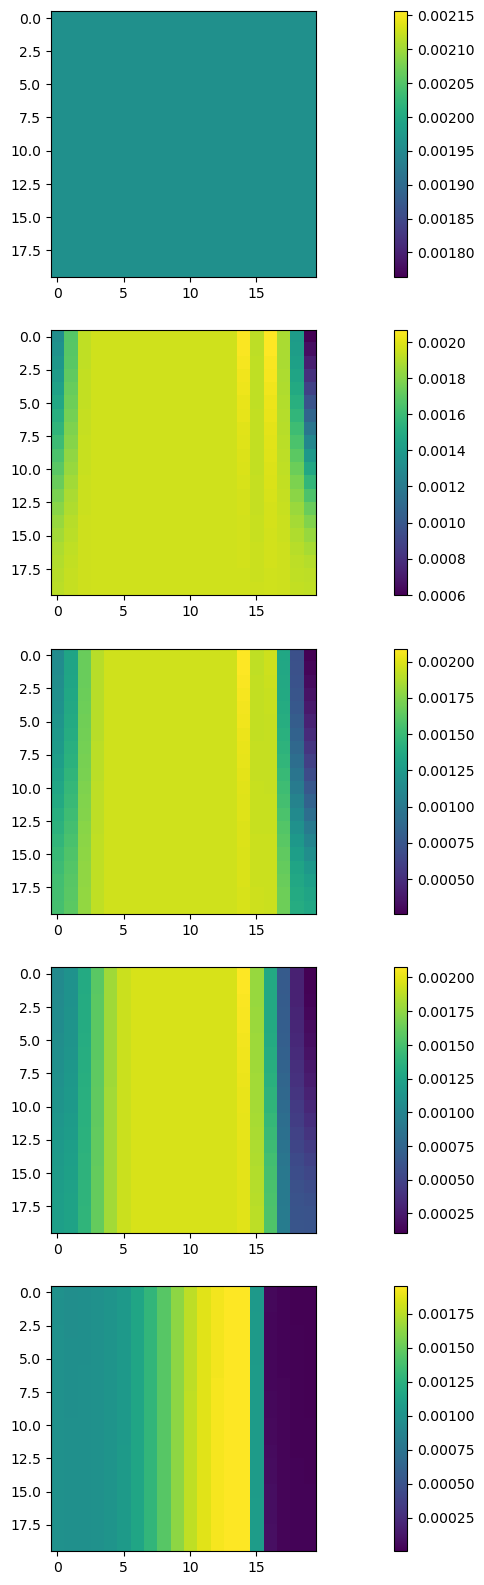

In [11]:
Species = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D007.UCN')
times = Species.get_times()
# Species.get_data()
Species.get_alldata().shape

plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(5, 1,i+1)
    plt.imshow(Species.get_alldata()[i, :, 0, :])
    print(Species.get_alldata()[i, :, 0, :].mean())
    plt.colorbar()

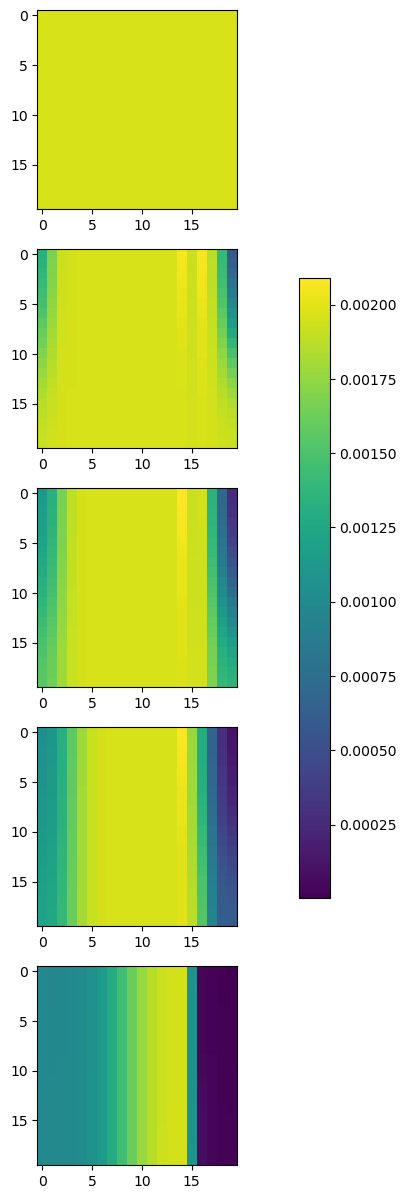

In [12]:
import matplotlib.cm as cm

# 假设 Species.get_alldata() 返回一个 numpy 数组
data = Species.get_alldata()

fig, axs = plt.subplots(5, 1, figsize=(20, 15))
norm = plt.Normalize(vmin=np.min(data), vmax=np.max(data))  # 归一化数据范围

# 创建子图并显示图像
for i in range(5):
    im = axs[i].imshow(data[i, :, 0, :], norm=norm, cmap=cm.viridis)
    # axs[i].axis('off')  # 如果你不想显示轴

# 创建一个共享的颜色条
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()

In [19]:
total_MAS = calculate_MAS_sums(filename=model_ws+'/PHT3D007.MAS', if_print=True)
total_MAS

Sum of each column:
TIME (D): 6217.50
TOTAL IN (KG): 12210.98
TOTAL OUT (KG): -12270.45
SOURCES (KG): 3550.01
SINKS (KG): -12156.37
NET MASS FROM FLUID-STORAGE (KG): 0.00
TOTAL MASS IN AQUIFER (KG): 25753.13
DISCREPANCY (TOTAL IN-OUT): -16.29
DISCREPANCY (ALTERNATIVE): -5.32


{'TIME (D)': 6217.5,
 'TOTAL IN (KG)': 12210.983,
 'TOTAL OUT (KG)': -12270.448,
 'SOURCES (KG)': 3550.0068,
 'SINKS (KG)': -12156.365000000002,
 'NET MASS FROM FLUID-STORAGE (KG)': 0.0,
 'TOTAL MASS IN AQUIFER (KG)': 25753.129999999997,
 'DISCREPANCY (TOTAL IN-OUT)': -16.291999999999998,
 'DISCREPANCY (ALTERNATIVE)': -5.321}